<a href="https://colab.research.google.com/github/ProfDoof/advent_of_code/blob/2022/day15.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Day 

## Load Data

In [5]:
from pathlib import Path

DAY = 15
DATA_FILE = Path.cwd() / 'drive' / 'MyDrive' / 'AdventOfCode' / 'aoc_data' / f'day{DAY}.txt'

data = DATA_FILE.read_text()

## Solution

In [3]:
%pip install shapely geopandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 36.6 MB/s 
     |████████████████████████████████| 16.6 MB 69.0 MB/s 
     |████████████████████████████████| 7.8 MB 64.8 MB/s 


In [2]:
test = '''
Sensor at x=2, y=18: closest beacon is at x=-2, y=15
Sensor at x=9, y=16: closest beacon is at x=10, y=16
Sensor at x=13, y=2: closest beacon is at x=15, y=3
Sensor at x=12, y=14: closest beacon is at x=10, y=16
Sensor at x=10, y=20: closest beacon is at x=10, y=16
Sensor at x=14, y=17: closest beacon is at x=10, y=16
Sensor at x=8, y=7: closest beacon is at x=2, y=10
Sensor at x=2, y=0: closest beacon is at x=2, y=10
Sensor at x=0, y=11: closest beacon is at x=2, y=10
Sensor at x=20, y=14: closest beacon is at x=25, y=17
Sensor at x=17, y=20: closest beacon is at x=21, y=22
Sensor at x=16, y=7: closest beacon is at x=15, y=3
Sensor at x=14, y=3: closest beacon is at x=15, y=3
Sensor at x=20, y=1: closest beacon is at x=15, y=3
'''

How many positions in row 2000000 cannot contain a beacon?  5564017
Possible beacon location:  2889605 3398893
with tuning frequency:  11558423398893


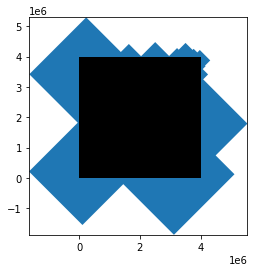

In [61]:
from geopandas.tools.util import MultiPolygon
import matplotlib.pyplot as plt
from matplotlib.path import Path
import matplotlib.patches as patches
from operator import itemgetter
from scipy.spatial.distance import cityblock
import re
import math
import geopandas as gpd
from shapely import linearrings, polygons, union_all, contains_xy, prepare, LineString, box, centroid, Polygon
from typing import Generator, Tuple, Callable


SENSOR_RE = re.compile('Sensor at x=(-?\d+), y=(-?\d+): closest beacon is at x=(-?\d+), y=(-?\d+)')

def find_num_beaconless(i_data: str, **kwargs):
    fig, ax = plt.subplots()
    x_max = -math.inf
    x_min = math.inf
    y_max = -math.inf
    y_min = math.inf

    rings = []
    for line in i_data.strip().split('\n'):
        sensor_x, sensor_y, beacon_x, beacon_y = [int(d) for d in SENSOR_RE.match(line).groups()]
        distance = cityblock([sensor_x, sensor_y], [beacon_x, beacon_y])

        x_max = max(x_max, sensor_x + distance)
        x_min = min(x_min, sensor_x - distance)
        y_max = max(y_max, sensor_y + distance)
        y_min = min(y_min, sensor_y - distance)

        verts = [
            [sensor_x + distance, sensor_y],
            [sensor_x, sensor_y - distance],
            [sensor_x - distance, sensor_y],
            [sensor_x, sensor_y + distance],
        ]

        rings.append(linearrings(verts))

    searched = union_all(polygons(rings))
    p = gpd.GeoSeries(searched)
    ax.set_xlim(x_min - 2, x_max + 2)
    ax.set_ylim(y_min - 2, y_max + 2)
    p.plot(ax=ax)

    searched_row = LineString([[x_min, kwargs['row']], [x_max, kwargs['row']]]).intersection(searched)
    print(f'How many positions in row {kwargs["row"]} cannot contain a beacon? ', int(searched_row.length))

    k_x_min, k_x_max = kwargs['smallest'], kwargs['largest']
    k_y_min, k_y_max = kwargs['smallest'], kwargs['largest']
    known_area = box(k_x_min, k_y_min, k_x_max, k_y_max)
    possible_distress_locs = known_area.difference(searched, grid_size=1)
    p = gpd.GeoSeries(known_area)
    p.plot(ax=ax, color='black')
    p = gpd.GeoSeries(known_area.difference(searched, grid_size=1))
    p.plot(ax=ax, color='orange')
    if isinstance(possible_distress_locs, Polygon):
        possible_distress_locs = MultiPolygon([possible_distress_locs])
    for poly in possible_distress_locs.geoms:
        c = centroid(poly)

        if c.x.is_integer() and c.y.is_integer():
            print("Possible beacon location: ", int(c.x), int(c.y))
            print("with tuning frequency: ", int(c.x) * 4000000 + int(c.y))

    plt.show()


find_num_beaconless(data, row=2000000, smallest=0, largest=4000000)